# <center>Dataset Information</center>

### Import the Necessary Libraries : 

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [36]:
data = pd.read_csv('Data\AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### Data Info :

In [37]:
data.shape

(144, 2)

In [38]:
data.columns

Index(['Month', '#Passengers'], dtype='object')

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


- **No null values** present in the data!

In [40]:
data.describe()

,#Passengers
count,144.00
mean,280.30
std,119.97
min,104.00
25%,180.00
50%,265.50
75%,360.50
max,622.00


In [41]:
data['Date'] = pd.to_datetime(data['Month'])
data = data.drop(columns = 'Month')
data = data.set_index('Date')
data = data.rename(columns = {'#Passengers':'Passengers'})
data.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


- Converting the datatype of the **Month** column to datetime datatype and setting it as the index of the dataset.
- Renaming the column **Month** to **Date** and **#Passengers** to **Passengers** as well.
- It is a monthly distributed data.

# <center>Time Series Analysis</center>

### Supportive Functions for Time Series Analysis :

In [44]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [46]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

<Axes: xlabel='Date'>

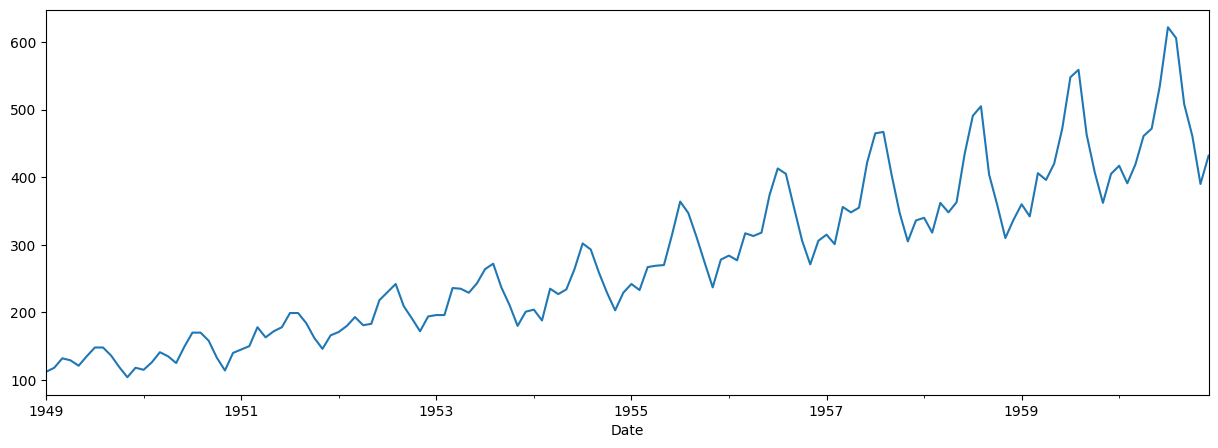

In [47]:
plt.figure(figsize = (15,5))
data['Passengers'].plot()

- From the above graph of **Passengers** data, we can say that it represents a **Multiplicative Model** as the data has increasing width & height of the peaks.
- Let us decompose the multiple components of the **Passengers** time series.

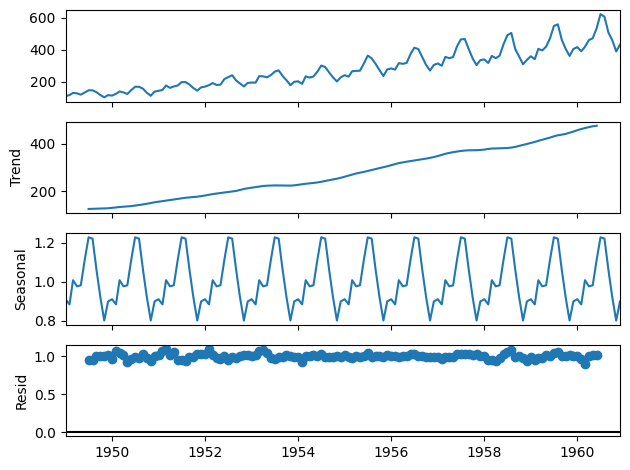

In [48]:
dec = sm.tsa.seasonal_decompose(data,period = 12, model = 'multiplicative').plot()
plt.show()

- Data clearly has a **linear uptrend**.
- A clear cut **seasonal** pattern of a 1 year duration is present in the data.
- We also need to check the statistical parameters w.r.t time. 

### Stationarity :

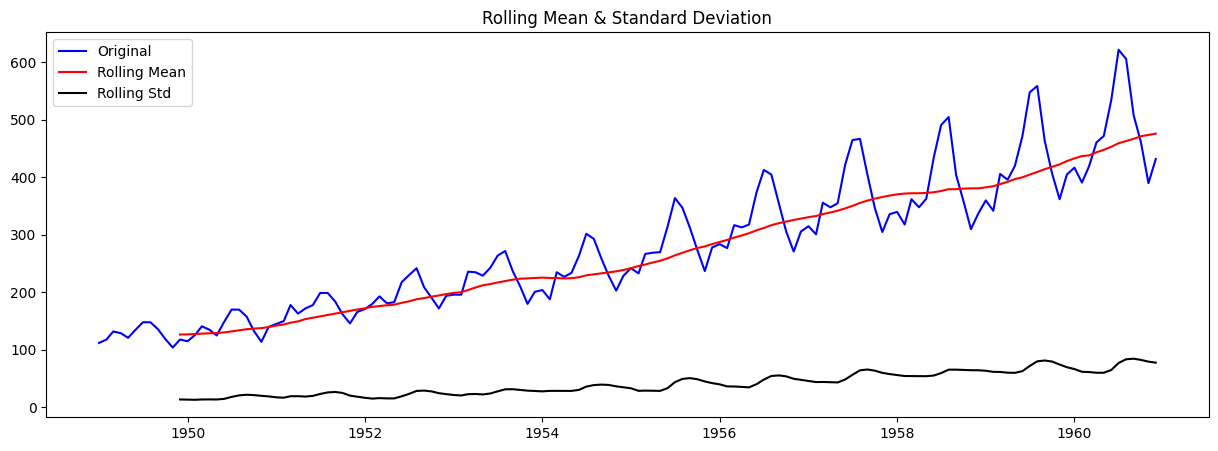

Results of Dickey-Fuller Test:
Test Statistic                  0.82
p-value                         0.99
#Lags Used                     13.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [49]:
test_stationarity(data['Passengers'])

- For the **Passengers** time series data, 
    - **Rolling Mean** is clearly variable with time. 
    - **Rolling Standard Deviation** is has some crests - troughs that vary according to the time.
    - **Test Statistic : (0.82)** > **Critical Value (5%) : (-2.88)**
    - **p-value (0.99)** > 0.05
- Hence, **Null Hypothesis** cannot be rejected and we can conclude that the above **Passengers** time series is **not stationary**.
- In order to eliminate trend, seasonality and make the time series stationary, we will use **differencing** i.e subtracting the previous value from it's next value. We will work on log values of the data from here!

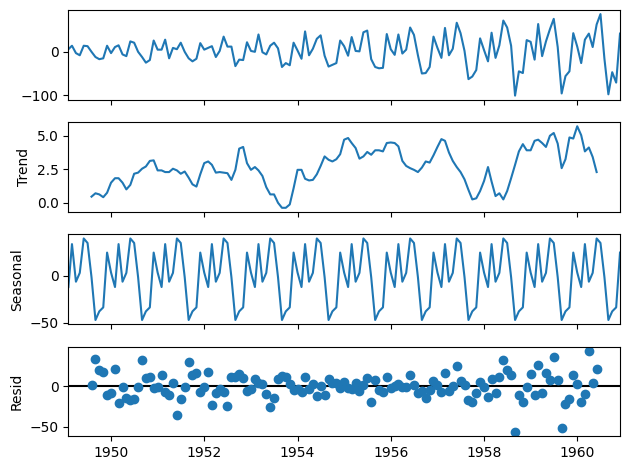

In [50]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

- We have taken the **log** of the data to deal with **stationarity** and **differencing** is done to handle **trend** and **seasonality**.
- **Trend** of the data has near about died down & their values have been reduced as well. However, **Seasonality** of the data is clearly visible.
- We now check the **stationarity** of the time series.

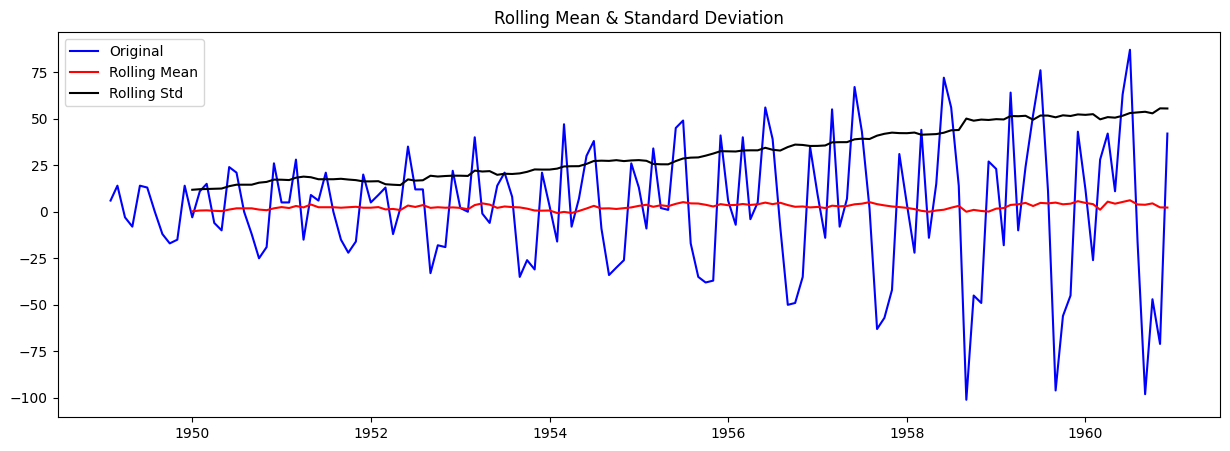

Results of Dickey-Fuller Test:
Test Statistic                 -2.83
p-value                         0.05
#Lags Used                     12.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [51]:
test_stationarity(data_diff)

- From the outputs of the **Augmented Dickey Fuller Test**,
    - **Rolling Mean** is very close to 0.
    - **Rolling Standard Deviation** displays a slight uptrend over time.
    - **Test Statistic : (-2.83)** > **Critical Value (5%) : (-2.88)**. 
    - **p-value (0.05)** > **0.05**
- From the above values, we will use the above time series despite it just fails on the **stationarity** test. 

# <center>Modeling</center>

## <center>ARIMA</center> 
### <center>Auto Regressive Integrated Moving Average</center> 

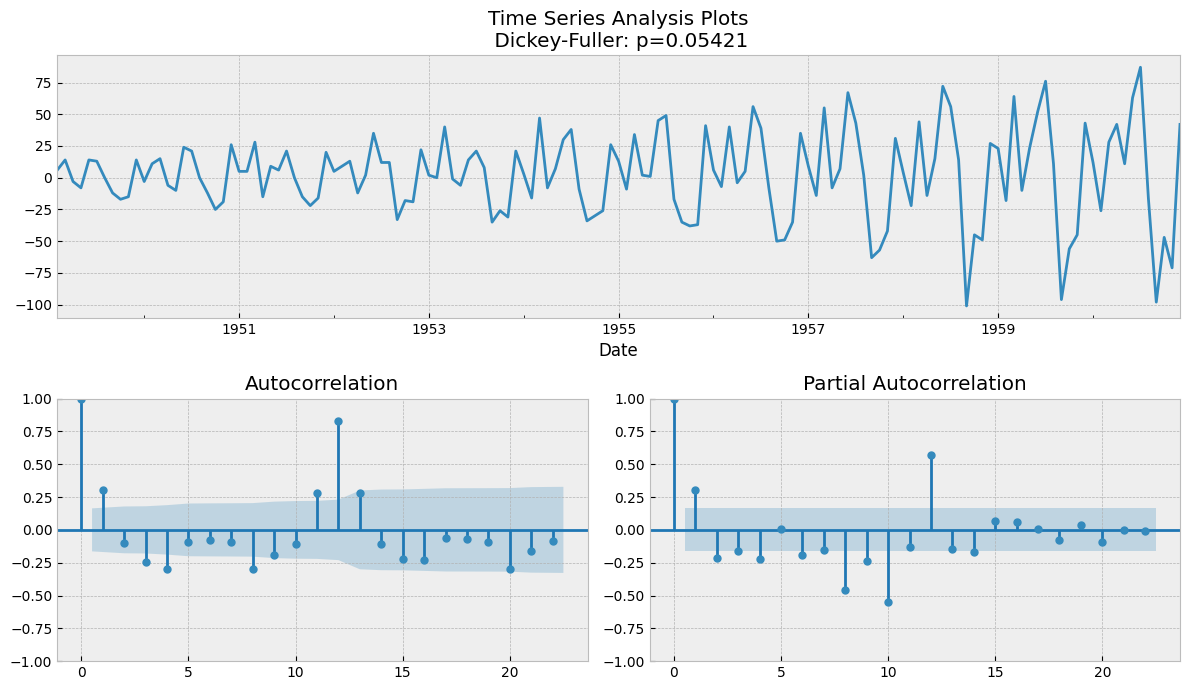

In [53]:
tsplot(data_diff['Passengers'])

- From the above plots, the following order of **ARIMA** model is selected from the selection criteria mentioned above :
    - **p** : 2
    - **d** : 1
    - **q** : 2
- The data passed for model fitting is the **Log_Passengers** data that is non-differenced data and non-stationary data.
- In order to make the series stationary, we difference the time series. Thus, this differencing of data is carried out by the ARIMA model with the help of the **d** parameter that provides info about the order of differencing.
- Thus, the parameters **p** and **q** are selected in such a way that we pass their values assuming the ARIMA model carries out the differencing process and makes the time series stationary.

In [54]:
model = ARIMA(data['Passengers'], order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Tue, 09 Dec 2025   AIC                           1353.347
Time:                        16:04:54   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.059      0.000       1.645       1.725
ar.L2         -0.9548      0.017    -55.419      0.000      -0.989      -0.921
ma.L1         -1.8432      0.125    -14.798      0.0

c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### In - Sample Forecasting :

- **In - Sample Forecasting** : Model forecasts values for the existing data points of the time series. It is similar to the train - test format for regression or classification problems. 
- We divide the data into train and test dataset. We reserve the last 30 elements for the test dataset and the remaining for the train dataset.
- For this **In - Sample Forecasting**, we use the **rolling** forecast method i.e we predict or forecast a single value and use this predicted value again for model fitting for predicting the next value.

In [55]:
size = int(len(data) - 30)
train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 435.368729, expected = 491.000000


C:\Users\saraz\AppData\Local\Temp\ipykernel_18596\1832696080.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[t]


predicted = 487.825560, expected = 505.000000
predicted = 484.761914, expected = 404.000000
predicted = 359.074739, expected = 359.000000
predicted = 380.902398, expected = 310.000000
predicted = 291.230057, expected = 337.000000
predicted = 336.928392, expected = 360.000000
predicted = 367.620919, expected = 342.000000
predicted = 360.294870, expected = 406.000000
predicted = 414.083702, expected = 396.000000
predicted = 378.520878, expected = 420.000000


c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 424.478770, expected = 472.000000
predicted = 459.477027, expected = 548.000000
predicted = 534.244023, expected = 559.000000


c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 523.514092, expected = 463.000000


c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 417.607632, expected = 407.000000


c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 366.689091, expected = 362.000000


c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 339.216335, expected = 405.000000
predicted = 411.312453, expected = 417.000000
predicted = 435.937976, expected = 391.000000
predicted = 418.796173, expected = 419.000000
predicted = 451.314909, expected = 461.000000
predicted = 488.381723, expected = 472.000000
predicted = 488.569078, expected = 535.000000
predicted = 532.219015, expected = 622.000000


c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 601.223605, expected = 606.000000


c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 563.032744, expected = 508.000000


c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 452.854029, expected = 461.000000


c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 414.985766, expected = 390.000000
predicted = 367.692207, expected = 432.000000


c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


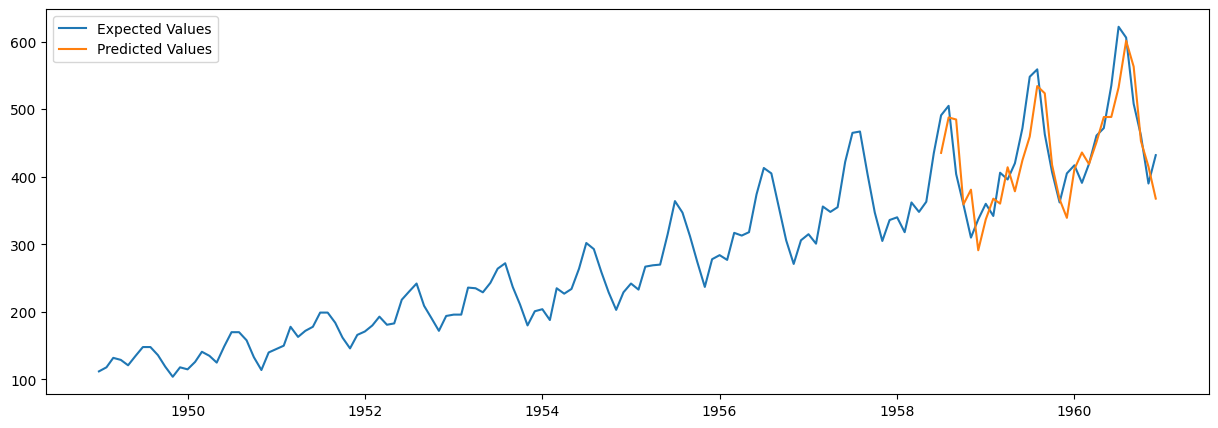

In [63]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

- **Predicted Values** and **Expected Values** are very close.

In [59]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 45.3501


- Test RMSE value is quite high.
- Presence of seasonality as well as order of the **ARIMA** model might have had an effect on the model performance. We will move on to **Out - Of - Sample Forecasting**.

### Out - of - Sample Forecasting :

- **Out - of - Sample Forecasting** : Model forecasts values for the future data points by imputing the datetime index values of the time series.
- We create a new dataframe with the future index values and same columns as the dataframe that we use for model fitting. 
- For this **Out - of - Sample Forecasting**, we use the **rolling** method by using **forecast function** and **predict function**.
- In the **rolling** method, we forecast or predict the next single value, use this predicted value again for model fitting that is then used for predicting the next value.

In [68]:
from pandas.tseries.offsets import DateOffset
future_dates = [data.index[-1] + DateOffset(weeks = x) for x in range(0,49)]

# New dataframe for storing the future values
df1 = pd.DataFrame(index = future_dates[1:],columns = data.columns)

forecast = pd.concat([data,df1])
forecast['ARIMA_Forecast_Function'] = np.nan
forecast['ARIMA_Predict_Function'] = np.nan
forecast.head()

,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN


- We create 2 new columns for storing the values forecasted or predicted into **ARIMA_Forecast_Function** and **ARIMA_Predict_Function**.

#### Forecast Function : 

In [75]:
ARIMA_history_f = [x for x in train]
f1 = []

for t in range(len(df1)):
    
    model = ARIMA(ARIMA_history_f, order = (2,1,2))
    model_fit = model.fit()
    
    output = model_fit.forecast()[0]
    
    ARIMA_history_f.append(output)
    f1.append(output)
    
for i in range(len(f1)):
    forecast.iloc[144 + i,1] = f1[i]
forecast.tail()

,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1961-10-05,NaN,388.71,NaN
1961-10-12,NaN,388.71,NaN
1961-10-19,NaN,388.71,NaN
1961-10-26,NaN,388.71,NaN
1961-11-02,NaN,388.71,NaN


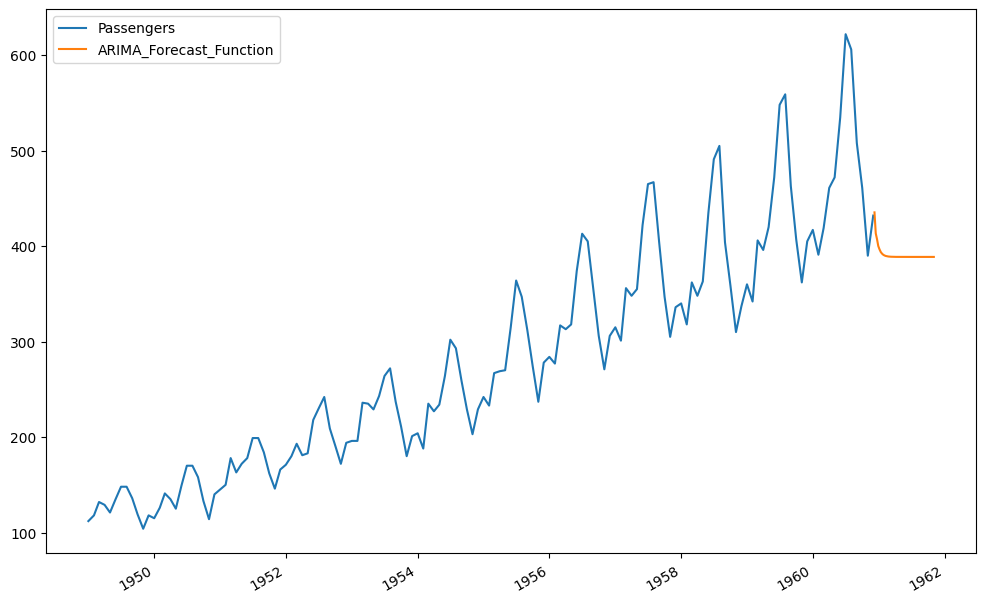

In [74]:
forecast[['Passengers','ARIMA_Forecast_Function']].plot(figsize = (12,8));

- Values generated by the **forecast_function** are rising. The model clearly did not understand the seasonal patterns of the data.

#### Predict Function :

In [93]:
ARIMA_history_p = [x for x in train]
f2 = []

for t in range(len(df1)):
    
    model = ARIMA(ARIMA_history_p, order = (2,1,2))
    model_fit = model.fit()
    
    output = model_fit.predict(start = len(ARIMA_history_p),end = len(ARIMA_history_p),typ = 'levels')[0]
    
    ARIMA_history_p.append(output)
    f2.append(output)
    
for i in range(len(f2)):
    forecast.iloc[144 + i,2] = f2[i]
forecast.tail()

c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1961-10-05,NaN,388.71,388.71
1961-10-12,NaN,388.71,388.71
1961-10-19,NaN,388.71,388.71
1961-10-26,NaN,388.71,388.71
1961-11-02,NaN,388.71,388.71


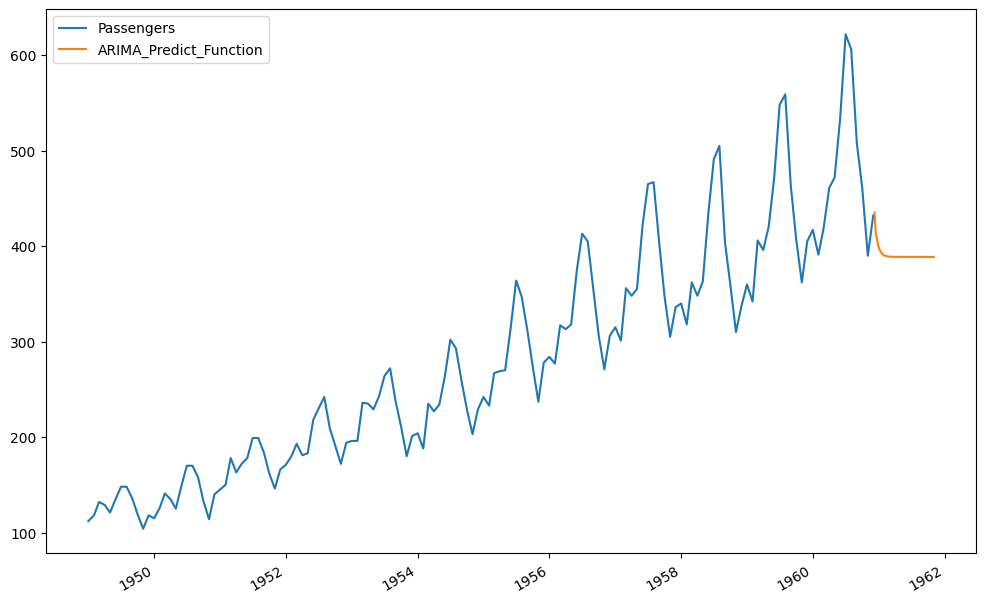

In [94]:
forecast[['Passengers','ARIMA_Predict_Function']].plot(figsize = (12,8));

- Similar pattern can be observed for the values generated by the **predict_function**. 
- Let's compare the values generated by the **forecast_function** and **predict_function**.

In [95]:
sum(f1) == sum(f2)

np.True_

- For the above trained **ARIMA** model, values generated by **forecast_function** and **predict function** are either exactly identical or just differ by a few decimal points!
- The model clearly did not capture the **seasonal patterns** of the data.

## <center>SARIMA</center>
### <center>Seasonal Auto Regressive Integrated Moving Average</center> 

- **SARIMA** model is an extension of the ARIMA model that can handle the seasonal effects of the data.
- It has kind of 2 orders **(p,d,q) x (P,D,Q,M)**. 
- **(p,d,q)** is the order that is similar to the order of the **ARIMA** model. 
- **(P,D,Q,M)** is known as the Seasonal Order where **(P,D,Q)** are similar to the **(p,d,q)** of the ARIMA model. 
- It's selection criteria is similar as well with an important condition i.e to handle the seasonality by differencing the data with the frequency of seasonal period or periodicity, **M** and check the **PACF** & **ACF** values at the **Mth** lag value. 

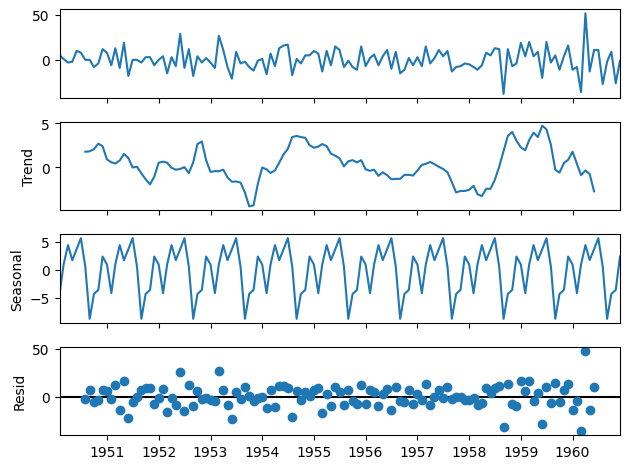

In [39]:
data_diff_seas = data_diff.diff(12)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 12)
dec.plot()
plt.show()

- Our data is in **monthly format** and the **seasonal period is of 1 year**.
- Hence, we difference the already differenced data by a periodicity, **M**, value of 12.
- The seasonality of the data has not completely died down but it's values have been dropped.
- We will check this seasonal differenced data for stationarity.

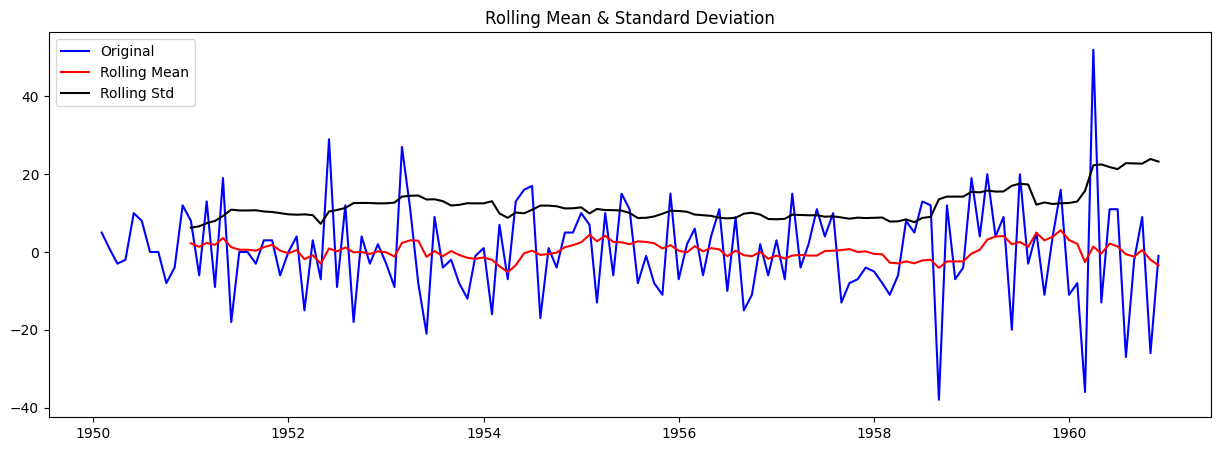

Results of Dickey-Fuller Test:
Test Statistic                -15.60
p-value                         0.00
#Lags Used                      0.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [40]:
test_stationarity(data_diff_seas['Passengers'])

- From the outputs of the **Augmented Dickey Fuller Test**,
    - **Rolling Mean** is very close to 0.
    - **Rolling Standard Deviation** is near about constant with certain crests - troughs present throughout.
    - **Critical Value (5%) : (-2.88)** > **Test Statistic : (-15.60)**. We can say that the time series is **stationary with 99%** confidence as the **Test Statistic** is less than **Critical Value (1%)** as well.
    - **0.05** > **p-value (0.00)**
- From these outputs, we can reject the **Null Hypothesis** and accept the **Alternate Hypothesis** i.e we can say that the above **time series is stationary**.

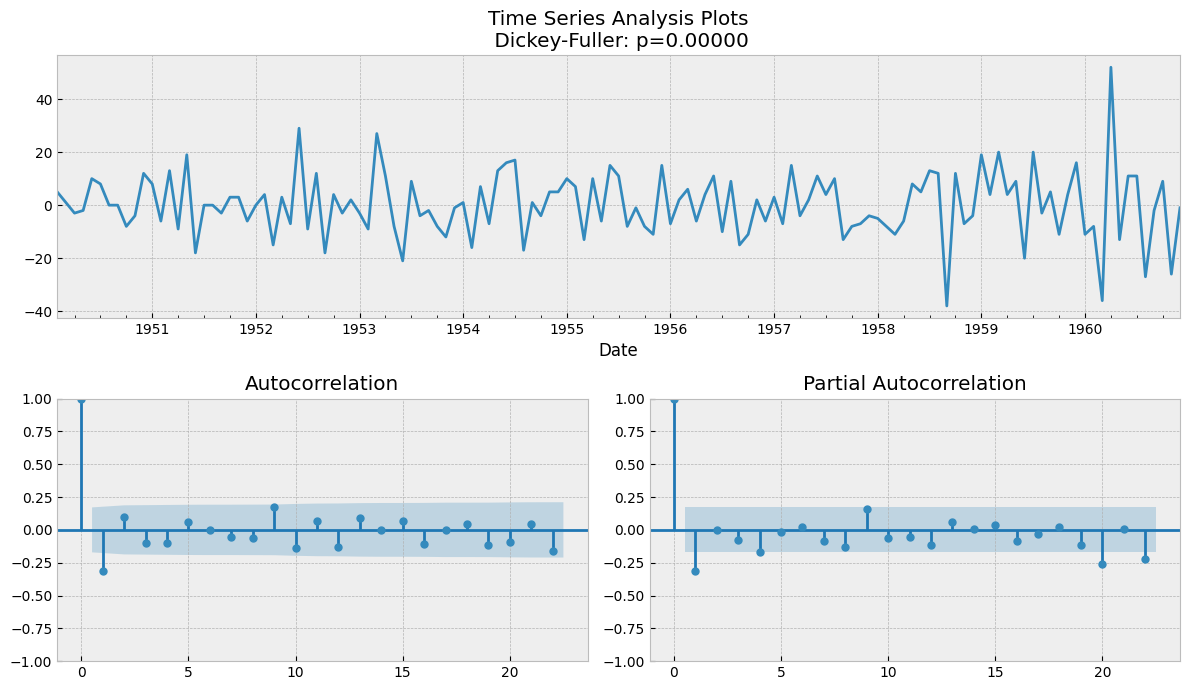

In [41]:
tsplot(data_diff_seas['Passengers'])

- For the **SARIMA** model, order of **(p,d,q)** will be same as the order of the **ARIMA** model above. 
- For **(P,D,Q,M)** :
    - **P** : 0
    - **D** : 1
    - **Q** : 1
    - **M** : 12

In [42]:
model = sm.tsa.statespace.SARIMAX(data['Passengers'],order = (2,1,2),seasonal_order = (0,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -503.968
Date:                              Mon, 08 Dec 2025   AIC                           1019.935
Time:                                      15:16:05   BIC                           1037.186
Sample:                                  01-01-1949   HQIC                          1026.945
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3966      0.422      0.940      0.347      -0.430       1.223
ar.L2          0.35

### In - Sample Forecasting :

- **In - Sample Forecasting** : Model forecasts values for the existing data points of the time series. It is similar to the train - test format for regression or classification problems. 
- We divide the data into train and test dataset. We reserve the last 30 elements for the test dataset and the remaining for the train dataset similar to the approach of **ARIMA** model.
- For this **In - Sample Forecasting**, we use the **rolling** forecast method i.e we predict or forecast a single value and use this predicted value again for model fitting for predicting the next value.

In [43]:
size = int(len(data) - 30)
train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]

print('\t SARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = sm.tsa.statespace.SARIMAX(history,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 SARIMA MODEL : In - Sample Forecasting 



C:\Users\saraz\AppData\Local\Temp\ipykernel_15480\1910389245.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[t]


predicted = 479.086151, expected = 491.000000
predicted = 490.553504, expected = 505.000000
predicted = 441.276121, expected = 404.000000
predicted = 357.272014, expected = 359.000000
predicted = 315.250222, expected = 310.000000
predicted = 347.832538, expected = 337.000000
predicted = 344.249070, expected = 360.000000
predicted = 336.835535, expected = 342.000000
predicted = 387.591516, expected = 406.000000
predicted = 387.333487, expected = 396.000000
predicted = 408.192790, expected = 420.000000
predicted = 485.988163, expected = 472.000000
predicted = 529.031343, expected = 548.000000
predicted = 551.914009, expected = 559.000000
predicted = 459.061267, expected = 463.000000
predicted = 411.970100, expected = 407.000000
predicted = 358.421156, expected = 362.000000
predicted = 384.945733, expected = 405.000000
predicted = 420.143790, expected = 417.000000
predicted = 397.755393, expected = 391.000000
predicted = 451.335514, expected = 419.000000
predicted = 415.675187, expected =

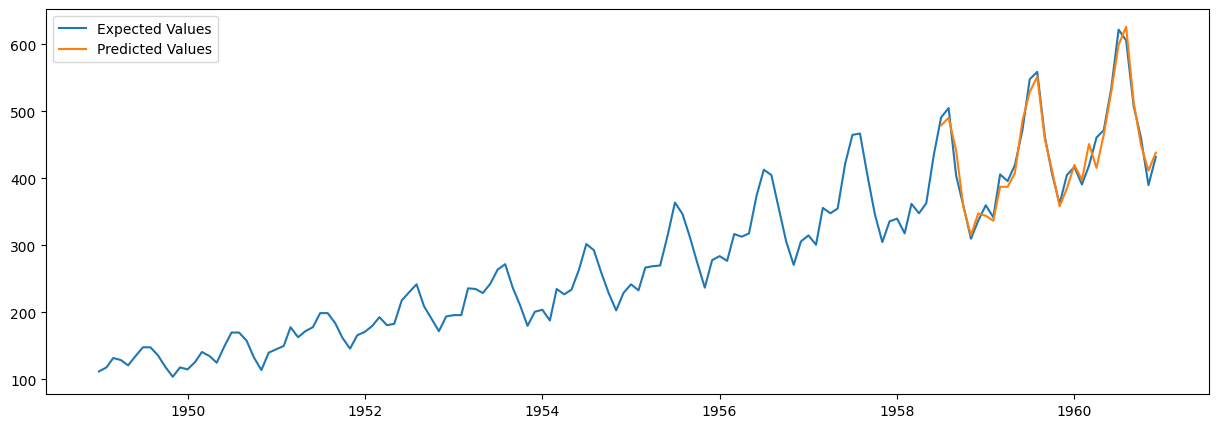

In [44]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

- The above trained **SARIMA model** has performed quite well in forecasting in - sample values

In [46]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 16.9253


- Test RMSE value is ok!

### Out - of - Sample Forecasting :

- **Out - of - Sample Forecasting** : Model forecasts values for the future data points by imputing the datetime index values of the time series.
- We create a new dataframe with the future index values and same columns as the dataframe that we use for model fitting. 
- For this **Out - of - Sample Forecasting**, we use the **non-rolling** method by using **forecast function** and **predict function**.
- In the **non-rolling** method, we forecast or predict all future values at once. We store these future values into 2 new columns **SARIMA_Forecast_Function** and **SARIMA_Predict_Function** in the existing forecast dataframe.

In [47]:
forecast['SARIMA_Forecast_Function'] = np.nan
forecast['SARIMA_Predict_Function'] = np.nan
forecast.head()

,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,NaN,NaN,NaN,NaN
1949-03-01,132,NaN,NaN,NaN,NaN
1949-04-01,129,NaN,NaN,NaN,NaN
1949-05-01,121,NaN,NaN,NaN,NaN


#### Forecast Function :

In [48]:
SARIMA_history_f = [x for x in train]
f3 = []

for t in (range(len(df1))):
    
    model = sm.tsa.statespace.SARIMAX(SARIMA_history_f,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()
    
    output = model_fit.forecast()[0]
    
    SARIMA_history_f.append(output)
    f3.append(output)
    
for i in range(len(f3)):
    forecast.iloc[144 + i,3] = f3[i]
forecast.tail()

c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
1961-10-05,NaN,NaN,388.71,423.79,NaN
1961-10-12,NaN,NaN,388.71,469.39,NaN
1961-10-19,NaN,NaN,388.71,456.61,NaN
1961-10-26,NaN,NaN,388.71,471.08,NaN
1961-11-02,NaN,NaN,388.71,542.70,NaN


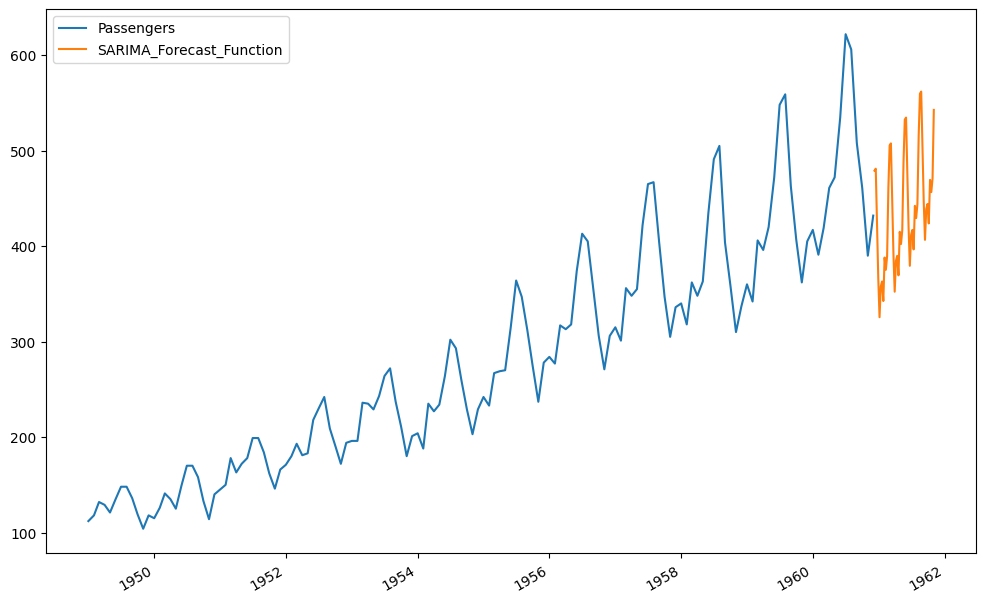

In [49]:
forecast[['Passengers','SARIMA_Forecast_Function']].plot(figsize = (12,8));

- From the above graph, we can say that **SARIMA** model understood the trend, seasonal pattern but it did not understand the increasing width of the seasonal pattern that is a characteristic feature of a **multiplicative** model.

#### Predict Function :

In [50]:
SARIMA_history_p = [x for x in train]
f4 = []

for t in range(len(df1)):
    
    model = sm.tsa.statespace.SARIMAX(SARIMA_history_p,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()
    
    output = model_fit.predict(start = len(SARIMA_history_p),end = len(SARIMA_history_p),typ = 'levels')[0]
    
    SARIMA_history_p.append(output)
    f4.append(output)
    
for i in range(len(f4)):
    forecast.iloc[144 + i,4] = f4[i]
forecast.tail()

c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\saraz\Desktop\Time_series_analysis\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
1961-10-05,NaN,NaN,388.71,423.79,423.79
1961-10-12,NaN,NaN,388.71,469.39,469.39
1961-10-19,NaN,NaN,388.71,456.61,456.61
1961-10-26,NaN,NaN,388.71,471.08,471.08
1961-11-02,NaN,NaN,388.71,542.70,542.70


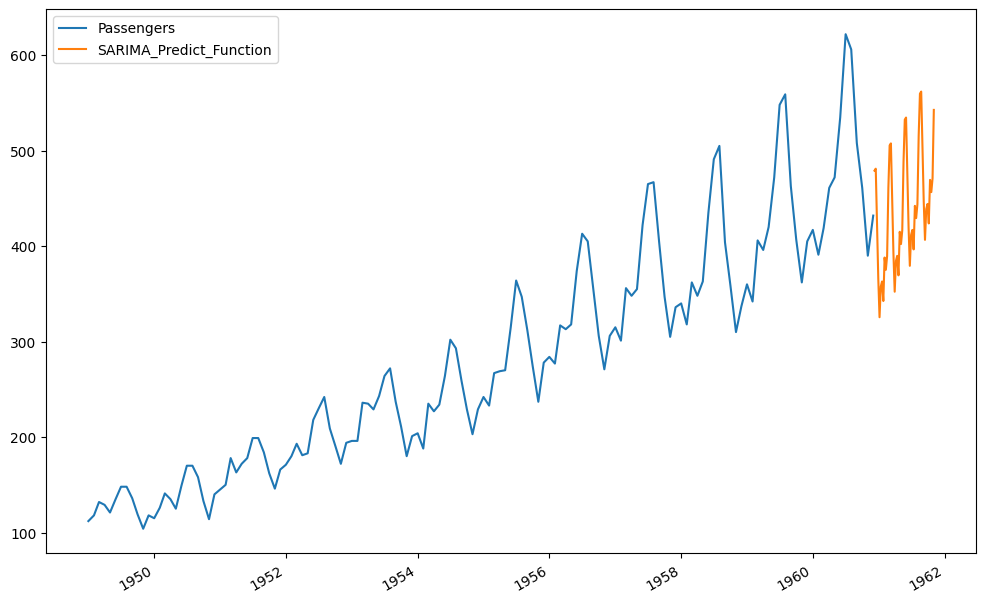

In [51]:
forecast[['Passengers','SARIMA_Predict_Function']].plot(figsize = (12,8));

- **SARIMA_Predict_Function** graph displays a similar pattern as the **SARIMA_Forecast_Function**.

In [52]:
sum(f3) == sum(f4)

np.True_

- Values of **SARIMA_Predict_Function** and **SARIMA_Forecast_Function** are identical or slightly different.